In [ ]:
## Notebook to run live estimation of image information saturation followed by QnR optimization on imswitch virtual micrsocope
# 2024-07-19
# Author: Hannah Heil



In [1]:
# Imports

import nanopyx
from nanopyx.core.transform._le_esrrf import eSRRF
from nanopyx.core.utils.timeit import timeit2
from nanopyx import run_esrrf_parameter_sweep
#from nanopyx.core.transform.sr_temporal_correlations import calculate_eSRRF_temporal_correlations
import numpy as np
from tqdm import tqdm
import imswitch
from imswitch.imcontrol.model.managers.rs232.VirtualMicroscopeManager import VirtualMicroscopy
import matplotlib.pyplot as plt
#for SSIM calculation
from skimage.metrics import structural_similarity as ssim
from IPython.display import display, clear_output
from PIL import Image


Cupy implementation is not available. Make sure you have the right version of Cupy and CUDA installed.
Optional dependecy Dask_image is not installed. Implementations using it will be ignored.
No module named 'javabridge'
Problem setting classpath. Switching to conventional viewer by setting __DEFAULTS__['IMG_VIEWER'] = 'NIP_VIEW' 


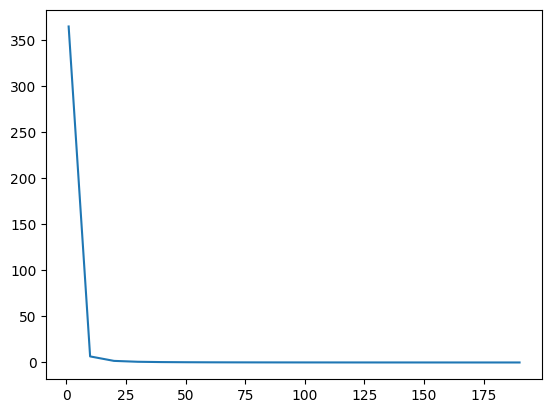

update_plot took 0.131938 seconds
treshold: 0.002239715413007483
reached treshold at: 0.0021849564144606273


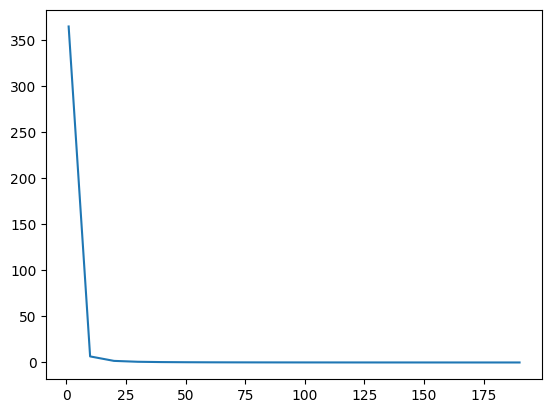

In [2]:
## Acquire an image stack from the imswitch virtual microscope until sampling is sufficient 

# Images are acquired with the "eSRRF" mode of the virtual microscope with will output the eSRRF reconstruction of all images 
# that have been acquired so far as well as the raw image stack. 
# The mean square error (MSE) is calculated betwen consecutive eSRRF reconstructions to see the trend of the image information. 
# If the difference between the most recent frames (mse_new) does not change more than 10% of the differenct of thoses preceding these (mse_old) 
# the image information saturation is reached and the loop ends. 
# If the MSE in two consecutive frames is smaller than 10% of the MSE in the first frame, the image information saturation is reached and the loop ends.
#___________________________________________#
##Functions: 

#Calculate MSE
@timeit2
def calculate_mse(imageA, imageB):
    # the 'Mean Squared Error' between the two images is the
    # sum of the squared difference between the two images;
    # NOTE: the two images must have the same dimension
    # Check if the images have the same dimensions
    if imageA.shape != imageB.shape:
        raise ValueError("Input images must have the same dimensions.")

    err_value = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err_value /= float(imageA.shape[0] * imageA.shape[1])
    # return the MSE, the lower the error, the more "similar"
    # the two images are
    return err_value

#Calculate SSIM

@timeit2
def calculate_ssim(imageA, imageB):
    # Check if the images have the same dimensions
    if imageA.shape != imageB.shape:
        raise ValueError("Input images must have the same dimensions.")
    # Get data range
    range=np.max(imageA)-np.min(imageA)
    # Compute the SSIM between the two images
    ssim_value, _ = ssim(imageA, imageB, full=True, data_range=range)

    return ssim_value

# Function to update the plot
@timeit2
def update_plot(x_data, y_data):
    line.set_xdata(x_data)
    line.set_ydata(y_data)
    ax.relim()
    ax.autoscale_view()
    fig.canvas.draw()
    fig.canvas.flush_events()
    clear_output(wait=True)
    display(fig)

#___________________________________________#

## Main:
# Initialize the plot
plt.ion()
fig, ax = plt.subplots()
line, = ax.plot([], [])

# Initialize the virtual microscope
microscope = VirtualMicroscopy(mode="eSRRF", imagePath="/Users/hannahheil/Documents/GitHub/ImSwitch/imswitch/_data/images/Grid.jpg") # for now options are: example or SMLM
microscope.camera.return_raw = True
microscope.illuminator.set_intensity(intensity=5000)
microscope.positioner.move(x=-0, y=0, z=0, is_absolute=True)
#microscope.camera.crop(hpos=0, vpos=0, hsize=1000, vsize=1000) # Optional cropping of the camera ROI, not implemented yet for virtual camera


eSRRF_AVG_old, stack_old = microscope.camera.getLast() #get first frame
eSRRF_AVG_new, stack_new = microscope.camera.getLast() #get second frame

mse_new=calculate_mse(eSRRF_AVG_old, eSRRF_AVG_new)
#ssim_new=calculate_ssim(eSRRF_AVG_old, eSRRF_AVG_new) # otional SSIM calculation, more robust but much slower
mse_array=[]
#ssim_array=[] # for SSIM option
mse_array=[mse_new]
#ssim_array=[ssim_new] # fro SSIM option
x_data=[1] #counter for the frame number

count=1
# run acquisition loop until satruation treshold is reached
while True:
    count=count+1
    mse_old=mse_new
    #ssim_old=ssim_new #for SSIM option
    eSRRF_AVG_old=eSRRF_AVG_new 
    eSRRF_AVG_new, stack = microscope.camera.getLast()
    if count % 10 == 0: #update plot every 10 frames
        x_data.append(count)
        mse_new=calculate_mse(eSRRF_AVG_old, eSRRF_AVG_new)
        #ssim_new=calculate_ssim(eSRRF_AVG_old, eSRRF_AVG_new) # for SSIM option
        mse_array.append(mse_new)
        #ssim_array.append(ssim_new)   # for SSIM option
        update_plot(x_data, mse_array) 
        if abs(mse_old-mse_new) < 0.1*mse_old:
            print("treshold:", 0.1*mse_old)
            print("reached treshold at:", mse_old-mse_new)
            break

plt.ioff()
        

(191, 512, 512)
256 256
(191, 100, 100)


Parameters pairs:   0%|          | 0/30 [00:00<?, ?pairs/s]

Querying the Agent...
Agent chose: opencl


/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/liquid_engine/liquid_engine.py:310: ResourceWarning: unclosed file <_io.TextIOWrapper name='/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/nanopyx/core/transform/_le_interpolation_catmull_rom_.cl' mode='r' encoding='UTF-8'>
  kernel_str = open(cl_file).read()
/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/liquid_engine/liquid_engine.py:310: ResourceWarning: unclosed file <_io.TextIOWrapper name='/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/nanopyx/core/transform/_le_roberts_cross_gradients.cl' mode='r' encoding='UTF-8'>
  kernel_str = open(cl_file).read()
/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/liquid_engine/liquid_engine.py:310: ResourceWarning: unclosed file <_io.TextIOWrapper name='/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/nanop

Agent: eSRRF_ST using opencl ran in 0.27836499399995773 seconds


Parameters pairs:   3%|▎         | 1/30 [00:01<00:48,  1.67s/pairs]

Querying the Agent...
Agent chose: opencl


/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/liquid_engine/liquid_engine.py:310: ResourceWarning: unclosed file <_io.TextIOWrapper name='/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/nanopyx/core/transform/_le_interpolation_catmull_rom_.cl' mode='r' encoding='UTF-8'>
  kernel_str = open(cl_file).read()
/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/liquid_engine/liquid_engine.py:310: ResourceWarning: unclosed file <_io.TextIOWrapper name='/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/nanopyx/core/transform/_le_roberts_cross_gradients.cl' mode='r' encoding='UTF-8'>
  kernel_str = open(cl_file).read()
/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/liquid_engine/liquid_engine.py:310: ResourceWarning: unclosed file <_io.TextIOWrapper name='/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/nanop

Agent: eSRRF_ST using opencl ran in 0.3544847819998722 seconds


Parameters pairs:   7%|▋         | 2/30 [00:03<00:48,  1.74s/pairs]

Querying the Agent...
Agent chose: opencl


/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/liquid_engine/liquid_engine.py:310: ResourceWarning: unclosed file <_io.TextIOWrapper name='/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/nanopyx/core/transform/_le_interpolation_catmull_rom_.cl' mode='r' encoding='UTF-8'>
  kernel_str = open(cl_file).read()
/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/liquid_engine/liquid_engine.py:310: ResourceWarning: unclosed file <_io.TextIOWrapper name='/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/nanopyx/core/transform/_le_roberts_cross_gradients.cl' mode='r' encoding='UTF-8'>
  kernel_str = open(cl_file).read()
/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/liquid_engine/liquid_engine.py:310: ResourceWarning: unclosed file <_io.TextIOWrapper name='/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/nanop

Agent: eSRRF_ST using opencl ran in 0.4412370009999904 seconds


Parameters pairs:  10%|█         | 3/30 [00:05<00:51,  1.92s/pairs]

Querying the Agent...
Agent chose: opencl


/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/liquid_engine/liquid_engine.py:310: ResourceWarning: unclosed file <_io.TextIOWrapper name='/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/nanopyx/core/transform/_le_interpolation_catmull_rom_.cl' mode='r' encoding='UTF-8'>
  kernel_str = open(cl_file).read()
/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/liquid_engine/liquid_engine.py:310: ResourceWarning: unclosed file <_io.TextIOWrapper name='/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/nanopyx/core/transform/_le_roberts_cross_gradients.cl' mode='r' encoding='UTF-8'>
  kernel_str = open(cl_file).read()
/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/liquid_engine/liquid_engine.py:310: ResourceWarning: unclosed file <_io.TextIOWrapper name='/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/nanop

Agent: eSRRF_ST using opencl ran in 0.5620181080000748 seconds


Parameters pairs:  13%|█▎        | 4/30 [00:07<00:52,  2.02s/pairs]

Querying the Agent...
Agent chose: opencl


/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/liquid_engine/liquid_engine.py:310: ResourceWarning: unclosed file <_io.TextIOWrapper name='/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/nanopyx/core/transform/_le_interpolation_catmull_rom_.cl' mode='r' encoding='UTF-8'>
  kernel_str = open(cl_file).read()
/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/liquid_engine/liquid_engine.py:310: ResourceWarning: unclosed file <_io.TextIOWrapper name='/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/nanopyx/core/transform/_le_roberts_cross_gradients.cl' mode='r' encoding='UTF-8'>
  kernel_str = open(cl_file).read()
/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/liquid_engine/liquid_engine.py:310: ResourceWarning: unclosed file <_io.TextIOWrapper name='/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/nanop

Agent: eSRRF_ST using opencl ran in 0.6874113300000317 seconds


Parameters pairs:  17%|█▋        | 5/30 [00:10<00:52,  2.12s/pairs]

Querying the Agent...
Agent chose: opencl


/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/liquid_engine/liquid_engine.py:310: ResourceWarning: unclosed file <_io.TextIOWrapper name='/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/nanopyx/core/transform/_le_interpolation_catmull_rom_.cl' mode='r' encoding='UTF-8'>
  kernel_str = open(cl_file).read()
/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/liquid_engine/liquid_engine.py:310: ResourceWarning: unclosed file <_io.TextIOWrapper name='/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/nanopyx/core/transform/_le_roberts_cross_gradients.cl' mode='r' encoding='UTF-8'>
  kernel_str = open(cl_file).read()
/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/liquid_engine/liquid_engine.py:310: ResourceWarning: unclosed file <_io.TextIOWrapper name='/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/nanop

Agent: eSRRF_ST using opencl ran in 0.2968486419999863 seconds


Parameters pairs:  20%|██        | 6/30 [00:12<00:49,  2.07s/pairs]

Querying the Agent...
Agent chose: opencl


/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/liquid_engine/liquid_engine.py:310: ResourceWarning: unclosed file <_io.TextIOWrapper name='/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/nanopyx/core/transform/_le_interpolation_catmull_rom_.cl' mode='r' encoding='UTF-8'>
  kernel_str = open(cl_file).read()
/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/liquid_engine/liquid_engine.py:310: ResourceWarning: unclosed file <_io.TextIOWrapper name='/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/nanopyx/core/transform/_le_roberts_cross_gradients.cl' mode='r' encoding='UTF-8'>
  kernel_str = open(cl_file).read()
/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/liquid_engine/liquid_engine.py:310: ResourceWarning: unclosed file <_io.TextIOWrapper name='/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/nanop

Agent: eSRRF_ST using opencl ran in 0.3674655889999485 seconds


Parameters pairs:  23%|██▎       | 7/30 [00:14<00:48,  2.10s/pairs]

Querying the Agent...
Agent chose: opencl


/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/liquid_engine/liquid_engine.py:310: ResourceWarning: unclosed file <_io.TextIOWrapper name='/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/nanopyx/core/transform/_le_interpolation_catmull_rom_.cl' mode='r' encoding='UTF-8'>
  kernel_str = open(cl_file).read()
/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/liquid_engine/liquid_engine.py:310: ResourceWarning: unclosed file <_io.TextIOWrapper name='/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/nanopyx/core/transform/_le_roberts_cross_gradients.cl' mode='r' encoding='UTF-8'>
  kernel_str = open(cl_file).read()
/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/liquid_engine/liquid_engine.py:310: ResourceWarning: unclosed file <_io.TextIOWrapper name='/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/nanop

Agent: eSRRF_ST using opencl ran in 0.4677819850001015 seconds


Parameters pairs:  27%|██▋       | 8/30 [00:16<00:46,  2.12s/pairs]

Querying the Agent...
Agent chose: opencl


/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/liquid_engine/liquid_engine.py:310: ResourceWarning: unclosed file <_io.TextIOWrapper name='/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/nanopyx/core/transform/_le_interpolation_catmull_rom_.cl' mode='r' encoding='UTF-8'>
  kernel_str = open(cl_file).read()
/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/liquid_engine/liquid_engine.py:310: ResourceWarning: unclosed file <_io.TextIOWrapper name='/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/nanopyx/core/transform/_le_roberts_cross_gradients.cl' mode='r' encoding='UTF-8'>
  kernel_str = open(cl_file).read()
/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/liquid_engine/liquid_engine.py:310: ResourceWarning: unclosed file <_io.TextIOWrapper name='/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/nanop

Agent: eSRRF_ST using opencl ran in 0.5766525740000361 seconds


Parameters pairs:  30%|███       | 9/30 [00:18<00:45,  2.16s/pairs]

Querying the Agent...
Agent chose: opencl


/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/liquid_engine/liquid_engine.py:310: ResourceWarning: unclosed file <_io.TextIOWrapper name='/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/nanopyx/core/transform/_le_interpolation_catmull_rom_.cl' mode='r' encoding='UTF-8'>
  kernel_str = open(cl_file).read()
/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/liquid_engine/liquid_engine.py:310: ResourceWarning: unclosed file <_io.TextIOWrapper name='/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/nanopyx/core/transform/_le_roberts_cross_gradients.cl' mode='r' encoding='UTF-8'>
  kernel_str = open(cl_file).read()
/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/liquid_engine/liquid_engine.py:310: ResourceWarning: unclosed file <_io.TextIOWrapper name='/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/nanop

Agent: eSRRF_ST using opencl ran in 0.698933974000056 seconds


Parameters pairs:  33%|███▎      | 10/30 [00:21<00:46,  2.33s/pairs]

Querying the Agent...
Agent chose: opencl


/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/liquid_engine/liquid_engine.py:310: ResourceWarning: unclosed file <_io.TextIOWrapper name='/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/nanopyx/core/transform/_le_interpolation_catmull_rom_.cl' mode='r' encoding='UTF-8'>
  kernel_str = open(cl_file).read()
/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/liquid_engine/liquid_engine.py:310: ResourceWarning: unclosed file <_io.TextIOWrapper name='/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/nanopyx/core/transform/_le_roberts_cross_gradients.cl' mode='r' encoding='UTF-8'>
  kernel_str = open(cl_file).read()
/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/liquid_engine/liquid_engine.py:310: ResourceWarning: unclosed file <_io.TextIOWrapper name='/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/nanop

Agent: eSRRF_ST using opencl ran in 0.28779081199991197 seconds


Parameters pairs:  37%|███▋      | 11/30 [00:23<00:43,  2.30s/pairs]

Querying the Agent...
Agent chose: opencl


/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/liquid_engine/liquid_engine.py:310: ResourceWarning: unclosed file <_io.TextIOWrapper name='/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/nanopyx/core/transform/_le_interpolation_catmull_rom_.cl' mode='r' encoding='UTF-8'>
  kernel_str = open(cl_file).read()
/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/liquid_engine/liquid_engine.py:310: ResourceWarning: unclosed file <_io.TextIOWrapper name='/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/nanopyx/core/transform/_le_roberts_cross_gradients.cl' mode='r' encoding='UTF-8'>
  kernel_str = open(cl_file).read()
/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/liquid_engine/liquid_engine.py:310: ResourceWarning: unclosed file <_io.TextIOWrapper name='/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/nanop

Agent: eSRRF_ST using opencl ran in 0.361916772000086 seconds


Parameters pairs:  40%|████      | 12/30 [00:25<00:41,  2.30s/pairs]

Querying the Agent...
Agent chose: opencl


/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/liquid_engine/liquid_engine.py:310: ResourceWarning: unclosed file <_io.TextIOWrapper name='/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/nanopyx/core/transform/_le_interpolation_catmull_rom_.cl' mode='r' encoding='UTF-8'>
  kernel_str = open(cl_file).read()
/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/liquid_engine/liquid_engine.py:310: ResourceWarning: unclosed file <_io.TextIOWrapper name='/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/nanopyx/core/transform/_le_roberts_cross_gradients.cl' mode='r' encoding='UTF-8'>
  kernel_str = open(cl_file).read()
/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/liquid_engine/liquid_engine.py:310: ResourceWarning: unclosed file <_io.TextIOWrapper name='/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/nanop

Agent: eSRRF_ST using opencl ran in 0.4460942799998975 seconds


Parameters pairs:  43%|████▎     | 13/30 [00:28<00:40,  2.36s/pairs]

Querying the Agent...
Agent chose: opencl


/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/liquid_engine/liquid_engine.py:310: ResourceWarning: unclosed file <_io.TextIOWrapper name='/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/nanopyx/core/transform/_le_interpolation_catmull_rom_.cl' mode='r' encoding='UTF-8'>
  kernel_str = open(cl_file).read()
/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/liquid_engine/liquid_engine.py:310: ResourceWarning: unclosed file <_io.TextIOWrapper name='/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/nanopyx/core/transform/_le_roberts_cross_gradients.cl' mode='r' encoding='UTF-8'>
  kernel_str = open(cl_file).read()
/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/liquid_engine/liquid_engine.py:310: ResourceWarning: unclosed file <_io.TextIOWrapper name='/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/nanop

Agent: eSRRF_ST using opencl ran in 0.5710256820000268 seconds


Parameters pairs:  47%|████▋     | 14/30 [00:30<00:38,  2.41s/pairs]

Querying the Agent...
Agent chose: opencl


/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/liquid_engine/liquid_engine.py:310: ResourceWarning: unclosed file <_io.TextIOWrapper name='/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/nanopyx/core/transform/_le_interpolation_catmull_rom_.cl' mode='r' encoding='UTF-8'>
  kernel_str = open(cl_file).read()
/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/liquid_engine/liquid_engine.py:310: ResourceWarning: unclosed file <_io.TextIOWrapper name='/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/nanopyx/core/transform/_le_roberts_cross_gradients.cl' mode='r' encoding='UTF-8'>
  kernel_str = open(cl_file).read()
/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/liquid_engine/liquid_engine.py:310: ResourceWarning: unclosed file <_io.TextIOWrapper name='/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/nanop

Agent: eSRRF_ST using opencl ran in 0.832603201999973 seconds


Parameters pairs:  50%|█████     | 15/30 [00:33<00:37,  2.52s/pairs]

Querying the Agent...
Agent chose: opencl


/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/liquid_engine/liquid_engine.py:310: ResourceWarning: unclosed file <_io.TextIOWrapper name='/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/nanopyx/core/transform/_le_interpolation_catmull_rom_.cl' mode='r' encoding='UTF-8'>
  kernel_str = open(cl_file).read()
/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/liquid_engine/liquid_engine.py:310: ResourceWarning: unclosed file <_io.TextIOWrapper name='/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/nanopyx/core/transform/_le_roberts_cross_gradients.cl' mode='r' encoding='UTF-8'>
  kernel_str = open(cl_file).read()
/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/liquid_engine/liquid_engine.py:310: ResourceWarning: unclosed file <_io.TextIOWrapper name='/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/nanop

Agent: eSRRF_ST using opencl ran in 0.2817743699999937 seconds


Parameters pairs:  53%|█████▎    | 16/30 [00:35<00:34,  2.47s/pairs]

Querying the Agent...
Agent chose: opencl


/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/liquid_engine/liquid_engine.py:310: ResourceWarning: unclosed file <_io.TextIOWrapper name='/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/nanopyx/core/transform/_le_interpolation_catmull_rom_.cl' mode='r' encoding='UTF-8'>
  kernel_str = open(cl_file).read()
/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/liquid_engine/liquid_engine.py:310: ResourceWarning: unclosed file <_io.TextIOWrapper name='/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/nanopyx/core/transform/_le_roberts_cross_gradients.cl' mode='r' encoding='UTF-8'>
  kernel_str = open(cl_file).read()
/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/liquid_engine/liquid_engine.py:310: ResourceWarning: unclosed file <_io.TextIOWrapper name='/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/nanop

Agent: eSRRF_ST using opencl ran in 0.45232974100008505 seconds


Parameters pairs:  57%|█████▋    | 17/30 [00:38<00:32,  2.50s/pairs]

Querying the Agent...
Agent chose: opencl


/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/liquid_engine/liquid_engine.py:310: ResourceWarning: unclosed file <_io.TextIOWrapper name='/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/nanopyx/core/transform/_le_interpolation_catmull_rom_.cl' mode='r' encoding='UTF-8'>
  kernel_str = open(cl_file).read()
/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/liquid_engine/liquid_engine.py:310: ResourceWarning: unclosed file <_io.TextIOWrapper name='/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/nanopyx/core/transform/_le_roberts_cross_gradients.cl' mode='r' encoding='UTF-8'>
  kernel_str = open(cl_file).read()
/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/liquid_engine/liquid_engine.py:310: ResourceWarning: unclosed file <_io.TextIOWrapper name='/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/nanop

Agent: eSRRF_ST using opencl ran in 0.5415107609999268 seconds


Parameters pairs:  60%|██████    | 18/30 [00:41<00:29,  2.50s/pairs]

Querying the Agent...
Agent chose: opencl


/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/liquid_engine/liquid_engine.py:310: ResourceWarning: unclosed file <_io.TextIOWrapper name='/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/nanopyx/core/transform/_le_interpolation_catmull_rom_.cl' mode='r' encoding='UTF-8'>
  kernel_str = open(cl_file).read()
/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/liquid_engine/liquid_engine.py:310: ResourceWarning: unclosed file <_io.TextIOWrapper name='/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/nanopyx/core/transform/_le_roberts_cross_gradients.cl' mode='r' encoding='UTF-8'>
  kernel_str = open(cl_file).read()
/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/liquid_engine/liquid_engine.py:310: ResourceWarning: unclosed file <_io.TextIOWrapper name='/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/nanop

Agent: eSRRF_ST using opencl ran in 0.5659441840000454 seconds


Parameters pairs:  63%|██████▎   | 19/30 [00:43<00:27,  2.52s/pairs]

Querying the Agent...
Agent chose: opencl


/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/liquid_engine/liquid_engine.py:310: ResourceWarning: unclosed file <_io.TextIOWrapper name='/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/nanopyx/core/transform/_le_interpolation_catmull_rom_.cl' mode='r' encoding='UTF-8'>
  kernel_str = open(cl_file).read()
/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/liquid_engine/liquid_engine.py:310: ResourceWarning: unclosed file <_io.TextIOWrapper name='/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/nanopyx/core/transform/_le_roberts_cross_gradients.cl' mode='r' encoding='UTF-8'>
  kernel_str = open(cl_file).read()
/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/liquid_engine/liquid_engine.py:310: ResourceWarning: unclosed file <_io.TextIOWrapper name='/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/nanop

Agent: eSRRF_ST using opencl ran in 0.7153662970001733 seconds


Parameters pairs:  67%|██████▋   | 20/30 [00:46<00:26,  2.62s/pairs]

Querying the Agent...
Agent chose: opencl


/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/liquid_engine/liquid_engine.py:310: ResourceWarning: unclosed file <_io.TextIOWrapper name='/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/nanopyx/core/transform/_le_interpolation_catmull_rom_.cl' mode='r' encoding='UTF-8'>
  kernel_str = open(cl_file).read()
/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/liquid_engine/liquid_engine.py:310: ResourceWarning: unclosed file <_io.TextIOWrapper name='/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/nanopyx/core/transform/_le_roberts_cross_gradients.cl' mode='r' encoding='UTF-8'>
  kernel_str = open(cl_file).read()
/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/liquid_engine/liquid_engine.py:310: ResourceWarning: unclosed file <_io.TextIOWrapper name='/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/nanop

Agent: eSRRF_ST using opencl ran in 0.27301420200001303 seconds


Parameters pairs:  70%|███████   | 21/30 [00:48<00:22,  2.51s/pairs]

Querying the Agent...
Agent chose: opencl


/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/liquid_engine/liquid_engine.py:310: ResourceWarning: unclosed file <_io.TextIOWrapper name='/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/nanopyx/core/transform/_le_interpolation_catmull_rom_.cl' mode='r' encoding='UTF-8'>
  kernel_str = open(cl_file).read()
/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/liquid_engine/liquid_engine.py:310: ResourceWarning: unclosed file <_io.TextIOWrapper name='/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/nanopyx/core/transform/_le_roberts_cross_gradients.cl' mode='r' encoding='UTF-8'>
  kernel_str = open(cl_file).read()
/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/liquid_engine/liquid_engine.py:310: ResourceWarning: unclosed file <_io.TextIOWrapper name='/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/nanop

Agent: eSRRF_ST using opencl ran in 0.44050846300001467 seconds


Parameters pairs:  73%|███████▎  | 22/30 [00:51<00:19,  2.46s/pairs]

Querying the Agent...
Agent chose: opencl


/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/liquid_engine/liquid_engine.py:310: ResourceWarning: unclosed file <_io.TextIOWrapper name='/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/nanopyx/core/transform/_le_interpolation_catmull_rom_.cl' mode='r' encoding='UTF-8'>
  kernel_str = open(cl_file).read()
/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/liquid_engine/liquid_engine.py:310: ResourceWarning: unclosed file <_io.TextIOWrapper name='/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/nanopyx/core/transform/_le_roberts_cross_gradients.cl' mode='r' encoding='UTF-8'>
  kernel_str = open(cl_file).read()
/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/liquid_engine/liquid_engine.py:310: ResourceWarning: unclosed file <_io.TextIOWrapper name='/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/nanop

Agent: eSRRF_ST using opencl ran in 0.4498204589999659 seconds


Parameters pairs:  77%|███████▋  | 23/30 [00:53<00:17,  2.44s/pairs]

Querying the Agent...
Agent chose: opencl


/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/liquid_engine/liquid_engine.py:310: ResourceWarning: unclosed file <_io.TextIOWrapper name='/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/nanopyx/core/transform/_le_interpolation_catmull_rom_.cl' mode='r' encoding='UTF-8'>
  kernel_str = open(cl_file).read()
/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/liquid_engine/liquid_engine.py:310: ResourceWarning: unclosed file <_io.TextIOWrapper name='/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/nanopyx/core/transform/_le_roberts_cross_gradients.cl' mode='r' encoding='UTF-8'>
  kernel_str = open(cl_file).read()
/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/liquid_engine/liquid_engine.py:310: ResourceWarning: unclosed file <_io.TextIOWrapper name='/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/nanop

Agent: eSRRF_ST using opencl ran in 0.6531853720000527 seconds


Parameters pairs:  80%|████████  | 24/30 [00:56<00:15,  2.55s/pairs]

Querying the Agent...
Agent chose: opencl


/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/liquid_engine/liquid_engine.py:310: ResourceWarning: unclosed file <_io.TextIOWrapper name='/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/nanopyx/core/transform/_le_interpolation_catmull_rom_.cl' mode='r' encoding='UTF-8'>
  kernel_str = open(cl_file).read()
/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/liquid_engine/liquid_engine.py:310: ResourceWarning: unclosed file <_io.TextIOWrapper name='/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/nanopyx/core/transform/_le_roberts_cross_gradients.cl' mode='r' encoding='UTF-8'>
  kernel_str = open(cl_file).read()
/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/liquid_engine/liquid_engine.py:310: ResourceWarning: unclosed file <_io.TextIOWrapper name='/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/nanop

Agent: eSRRF_ST using opencl ran in 0.7942538540000896 seconds


Parameters pairs:  83%|████████▎ | 25/30 [00:58<00:12,  2.59s/pairs]

Querying the Agent...
Agent chose: opencl


/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/liquid_engine/liquid_engine.py:310: ResourceWarning: unclosed file <_io.TextIOWrapper name='/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/nanopyx/core/transform/_le_interpolation_catmull_rom_.cl' mode='r' encoding='UTF-8'>
  kernel_str = open(cl_file).read()
/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/liquid_engine/liquid_engine.py:310: ResourceWarning: unclosed file <_io.TextIOWrapper name='/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/nanopyx/core/transform/_le_roberts_cross_gradients.cl' mode='r' encoding='UTF-8'>
  kernel_str = open(cl_file).read()
/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/liquid_engine/liquid_engine.py:310: ResourceWarning: unclosed file <_io.TextIOWrapper name='/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/nanop

Agent: eSRRF_ST using opencl ran in 0.27875311999991936 seconds


Parameters pairs:  87%|████████▋ | 26/30 [01:01<00:10,  2.51s/pairs]

Querying the Agent...
Agent chose: opencl


/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/liquid_engine/liquid_engine.py:310: ResourceWarning: unclosed file <_io.TextIOWrapper name='/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/nanopyx/core/transform/_le_interpolation_catmull_rom_.cl' mode='r' encoding='UTF-8'>
  kernel_str = open(cl_file).read()
/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/liquid_engine/liquid_engine.py:310: ResourceWarning: unclosed file <_io.TextIOWrapper name='/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/nanopyx/core/transform/_le_roberts_cross_gradients.cl' mode='r' encoding='UTF-8'>
  kernel_str = open(cl_file).read()
/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/liquid_engine/liquid_engine.py:310: ResourceWarning: unclosed file <_io.TextIOWrapper name='/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/nanop

Agent: eSRRF_ST using opencl ran in 0.35876352700006464 seconds


Parameters pairs:  90%|█████████ | 27/30 [01:03<00:07,  2.53s/pairs]

Querying the Agent...
Agent chose: opencl


/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/liquid_engine/liquid_engine.py:310: ResourceWarning: unclosed file <_io.TextIOWrapper name='/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/nanopyx/core/transform/_le_interpolation_catmull_rom_.cl' mode='r' encoding='UTF-8'>
  kernel_str = open(cl_file).read()
/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/liquid_engine/liquid_engine.py:310: ResourceWarning: unclosed file <_io.TextIOWrapper name='/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/nanopyx/core/transform/_le_roberts_cross_gradients.cl' mode='r' encoding='UTF-8'>
  kernel_str = open(cl_file).read()
/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/liquid_engine/liquid_engine.py:310: ResourceWarning: unclosed file <_io.TextIOWrapper name='/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/nanop

Agent: eSRRF_ST using opencl ran in 0.4481985749998785 seconds


Parameters pairs:  93%|█████████▎| 28/30 [01:06<00:05,  2.54s/pairs]

Querying the Agent...
Agent chose: opencl


/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/liquid_engine/liquid_engine.py:310: ResourceWarning: unclosed file <_io.TextIOWrapper name='/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/nanopyx/core/transform/_le_interpolation_catmull_rom_.cl' mode='r' encoding='UTF-8'>
  kernel_str = open(cl_file).read()
/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/liquid_engine/liquid_engine.py:310: ResourceWarning: unclosed file <_io.TextIOWrapper name='/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/nanopyx/core/transform/_le_roberts_cross_gradients.cl' mode='r' encoding='UTF-8'>
  kernel_str = open(cl_file).read()
/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/liquid_engine/liquid_engine.py:310: ResourceWarning: unclosed file <_io.TextIOWrapper name='/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/nanop

Agent: eSRRF_ST using opencl ran in 0.7046399600001223 seconds


Parameters pairs:  97%|█████████▋| 29/30 [01:09<00:02,  2.59s/pairs]

Querying the Agent...
Agent chose: opencl


/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/liquid_engine/liquid_engine.py:310: ResourceWarning: unclosed file <_io.TextIOWrapper name='/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/nanopyx/core/transform/_le_interpolation_catmull_rom_.cl' mode='r' encoding='UTF-8'>
  kernel_str = open(cl_file).read()
/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/liquid_engine/liquid_engine.py:310: ResourceWarning: unclosed file <_io.TextIOWrapper name='/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/nanopyx/core/transform/_le_roberts_cross_gradients.cl' mode='r' encoding='UTF-8'>
  kernel_str = open(cl_file).read()
/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/liquid_engine/liquid_engine.py:310: ResourceWarning: unclosed file <_io.TextIOWrapper name='/Users/hannahheil/miniforge3/envs/imswitchhackathon/lib/python3.9/site-packages/nanop

Agent: eSRRF_ST using opencl ran in 0.7185262929999681 seconds


Parameters pairs: 100%|██████████| 30/30 [01:11<00:00,  2.40s/pairs]


[[0.87247068 0.86985147 0.86829752 0.86615396 0.81573975]
 [0.87071389 0.86727107 0.8643102  0.85926431 0.85333604]
 [0.86897796 0.86478603 0.85975516 0.84930712 0.82811671]
 [0.86740625 0.86232167 0.85436624 0.83338553 0.74867296]
 [0.86596096 0.85979956 0.84767485 0.80190676 0.50662464]
 [0.86459386 0.85715711 0.83882475 0.7290805  0.25982425]]
[[2.30317283 2.54215312 3.01075268 3.55716872 4.01975584]
 [2.19977546 2.47787619 2.75668073 3.31641293 4.16135883]
 [2.15148187 2.30317283 2.60985351 3.10618067 3.69114876]
 [2.15148187 2.25028706 2.47787619 2.92101336 3.55716872]
 [2.19977546 2.19977546 2.47787619 2.75668073 3.31641293]
 [2.15148187 2.19977546 2.4167695  2.60985351 3.10618067]]
(6, 5) (6, 5)
2.151481866836548
4.161358833312988
[[0.89407746 0.82283049 0.59004788 0.26857691 0.1035578 ]
 [0.91618249 0.8450552  0.7309274  0.40131835 0.075     ]
 [0.925      0.89407746 0.79679709 0.53135808 0.20803688]
 [0.925      0.90596185 0.8450552  0.64302273 0.26857691]
 [0.91618249 0.91618

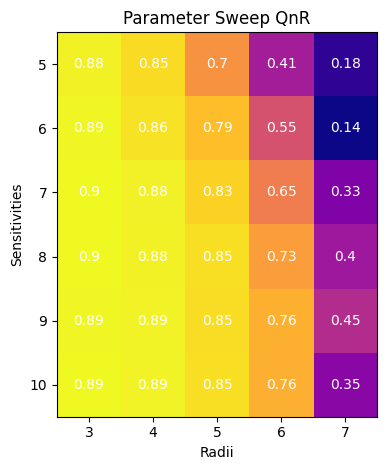

Optimal sensitivity is: 7; and optimal radius is: 3


In [12]:
## eSRRF Parameter optimization
# parameter sweep runs on central 100x100 pixel ROI of the image stack acquired in the previous celland outputs the QnR map for each radius and sensitivity.
# The resoluton estimation can be based on FRC or decorrelation (recomended).

##Parameters : 
radii = range(3,8,1) # radius sweep range (start, stop, step)
sensitivities = range(5,11,1) # sensitivity sweep range (start, stop, step)
global_mag = 2 #magnification   
temp_corr = "AVG" # temporal reconstruction mode: "AVG", "VAR" or "TAC2
use_decorr = True # resolution estimation based on FRC (False) or decorrelation (True)

global g_temp_corr
if temp_corr == "AVG":
    g_temp_corr = 1
elif temp_corr == "VAR":
    g_temp_corr = 2
elif temp_corr == "TAC2":
    g_temp_corr = 3

print(stack.shape)
stack=stack.reshape(microscope.camera.frameNumber,microscope.camera.SensorHeight,microscope.camera.SensorWidth)
center_x=int(abs(stack.shape[1]/2))
center_y=int(abs(stack.shape[2]/2))
print(center_x, center_y)
dataset_original = np.ascontiguousarray(stack[:,center_x-50:center_x+50,center_y-50:center_y+50], dtype=np.float32) #restrition to the center 100x100 pixel ROI
#dataset_original=stack
print(dataset_original.shape)
param_sweep_out = run_esrrf_parameter_sweep(dataset_original, magnification=global_mag, sensitivities=sensitivities, radii=radii, temporal_correlation=temp_corr, plot_sweep=True, return_qnr=True, use_decorr=use_decorr)

sens_idx, rad_idx = np.unravel_index(np.argmax(param_sweep_out), param_sweep_out.shape)
global optimal_sensitivity
optimal_sensitivity = sensitivities[sens_idx]
global optimal_radius
optimal_radius = radii[rad_idx]
print(f"Optimal sensitivity is: {optimal_sensitivity}; and optimal radius is: {optimal_radius}")


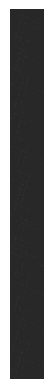

Saved NumPy array as a TIFF stack.


In [5]:
plt.imshow(stack, cmap='gray')
plt.axis('off')  # Hide axes
plt.show()

num_images = len(stack)
# Convert the NumPy array to a list of PIL.Image objects
image_list = [Image.fromarray(stack[i]) for i in range(num_images)]
# Save the list of images as a TIFF stack
image_list[0].save('image_stack.tif', save_all=True, append_images=image_list[1:], compression="tiff_deflate")

print("Saved NumPy array as a TIFF stack.")


#plt.imsave("/Users/hannahheil/Downloads/stack.tif", stack[1])


(1024, 1024)
(1024, 1024)


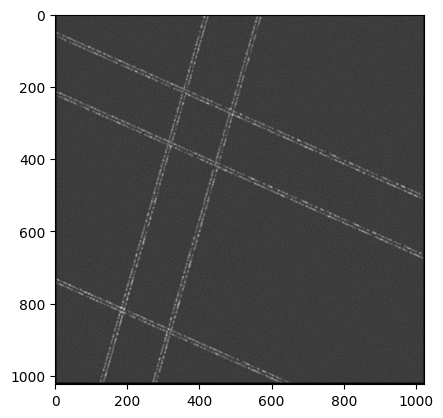

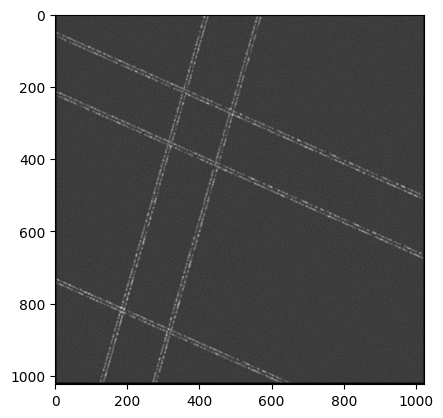

In [3]:
# Test visualization of the last two eSRRF frames
print(eSRRF_AVG_old.shape)
print(eSRRF_AVG_new.shape)
plt.imshow(eSRRF_AVG_old, cmap='gray',vmin=None, vmax=None)
plt.show()
plt.imshow(eSRRF_AVG_new, cmap='gray',vmin=None, vmax=None)
plt.show()

Defocus:0.0
Defocus:0.0
Agent: eSRRF_ST using threaded ran in 1.0856408999999871 seconds
Agent: eSRRF_ST using threaded ran in 1.1177974550000158 seconds
Agent: eSRRF_ST using threaded ran in 1.1594819470000175 seconds
Agent: eSRRF_ST using threaded ran in 1.2134593490000043 seconds
Agent: eSRRF_ST using threaded ran in 1.1103459970000245 seconds
Agent: eSRRF_ST using threaded ran in 1.1915133640000022 seconds
Agent: eSRRF_ST using threaded ran in 1.1540929939999955 seconds
Agent: eSRRF_ST using threaded ran in 1.470895664000011 seconds
Run type threaded was delayed in the previous run. Delay factor: 1.281435879709081, Delay probability: 0.14714829699410964
Agent: eSRRF_ST using threaded ran in 1.2914737519999733 seconds
Run type threaded was delayed in the previous run. Delay factor: 1.1228621191780277, Delay probability: 0.22284952208839376
Agent: eSRRF_ST using threaded ran in 1.2223596740000175 seconds
Agent: eSRRF_ST using threaded ran in 1.3937234269999976 seconds
Run type thread

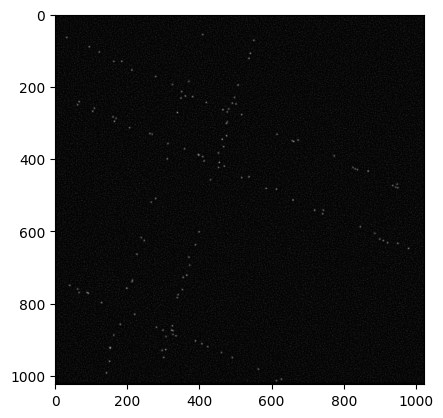

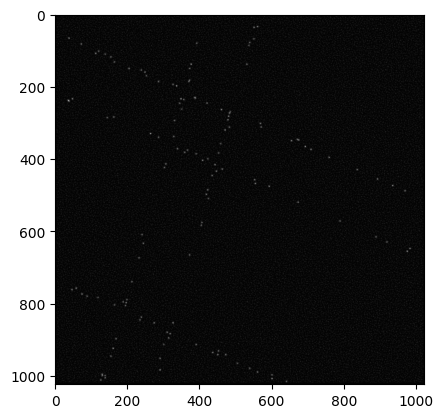

In [4]:
# Test acquisiton of 10 frames
microscope = VirtualMicroscopy(mode="eSRRF", imagePath="/Users/hannahheil/Documents/GitHub/ImSwitch/imswitch/_data/images/Grid.jpg") # for now options are: example or SMLM
microscope.camera.return_raw = True
microscope.illuminator.set_intensity(intensity=5000)
microscope.positioner.move(x=-0, y=0, z=0, is_absolute=True)

eSRRF_AVG_old, stack_old = microscope.camera.getLast() 
for i in range(10):
    eSRRF_AVG_new, stack_new = microscope.camera.getLast() 


plt.imshow(eSRRF_AVG_old, cmap='gray',vmin=None, vmax=None)
plt.show()
plt.imshow(eSRRF_AVG_new, cmap='gray',vmin=None, vmax=None)
plt.show()

In [10]:
sens_idx, rad_idx = np.unravel_index(np.argmax(param_sweep_out), param_sweep_out.shape)
global optimal_sensitivity
optimal_sensitivity = sensitivities[sens_idx]
global optimal_radius
optimal_radius = radii[rad_idx]
print(f"Optimal sensitivity is: {optimal_sensitivity}; and optimal radius is: {optimal_radius}")

Optimal sensitivity is: 4; and optimal radius is: 3
